<a href="https://colab.research.google.com/github/TREEofbusybeaver/Flight-Data-Analyzer/blob/master/uav_fab_wk2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

schrenk's approx

In [ ]:
import numpy as np

# -------- Wing geometry from your report --------
b_total = 1.999        # full span [m] (your design)
b = b_total            # shorthand
lam = 0.8              # taper ratio Ct/Cr
cr = 0.300             # root chord [m]
ct = 0.240             # tip chord [m]
b_mid = 0.2            # constant-chord center section (full-span) [m]
S = 0.546              # planform area [m^2] (your design)

# Derived spans
half_span = b/2
half_mid = b_mid/2     # half of the constant-chord section on one side
b_taper_half = half_span - half_mid  # tapered half-span length

# -------- Chord distribution c(y) with center constant-chord section --------
# y measured from centerline: y in [0, b/2]
def chord(y):
    # Constant-chord region
    if y <= half_mid + 1e-12:
        return cr
    # Linear taper from cr at y=half_mid to ct at y=b/2
    else:
        # linear interpolation across b_taper_half
        t = (y - half_mid) / b_taper_half   # goes 0 -> 1
        return cr + t*(ct - cr)

# -------- Elliptic spanwise lift baseline (unnormalized) --------
# Use classic half-ellipse shape: E(y) ~ sqrt(1 - (2y/b)^2)
def Lprime_elliptic_shape(y):
    xi = 2*y/b
    return np.sqrt(max(0.0, 1.0 - xi*xi))

# -------- Planform-proportional baseline (unnormalized) --------
# Schrenk assumes lift ~ chord locally, so use c(y) shape
def Lprime_planform_shape(y):
    return chord(y)

# -------- Build grid and compute shapes (half-span) --------
N = 401
y_half = np.linspace(0.0, half_span, N)

E = np.array([Lprime_elliptic_shape(y) for y in y_half])
P = np.array([Lprime_planform_shape(y) for y in y_half])

# Normalize E and P so that their full-span integrals each equal 1.0
# Full span integral = 2 * integral over half-span
def normalize_shape(yh, f):
    I_half = np.trapezoid(f, yh)
    I_full = 2.0 * I_half
    return f / I_full, I_full

E_norm, E_full_integral = normalize_shape(y_half, E)
P_norm, P_full_integral = normalize_shape(y_half, P)

# -------- Schrenk distribution (unit-total-lift before scaling) --------
Lprime_sch_half_norm = 0.5*(E_norm + P_norm)  # integrates to 1 over full span

# Scale to desired total lift L (e.g., load factor N times weight W)
MTOW = 10.88  # kg
g = 9.81      # m/s^2
Nlf = 1.0     # load factor
L_total = Nlf * MTOW * g # Total Lift in N

# Scale the normalized distributions
Lprime_sch_half = Lprime_sch_half_norm * L_total
Lprime_elliptic_half = E_norm * L_total
Lprime_planform_half = P_norm * L_total


# -------- Mirror to full span for convenience (optional for this request) --------
# y_full = np.concatenate((-y_half[::-1], y_half[1:]))  # avoid duplicate zero
# Lprime_full = np.concatenate((Lprime_sch_half[::-1], Lprime_sch_half[1:]))


# Sanity check: integral over full span should be L_total if scaled
# I_check = np.trapezoid(Lprime_full, y_full)
# print(f"Full-span integral of L'(y) = {I_check:.6f} (should be {L_total:.6f} if scaled)")

# -------- Optional: compute shear and bending moment (cantilever) --------
# For structural sizing, work on half-span with cantilever BCs at tip: S(b/2)=0, M(b/2)=0
# Here we demonstrate half-span net lift (no weight subtraction). Replace with q(y)=L'(y)-w'(y) as needed.
q_half = Lprime_sch_half  # replace with net load per unit span if needed

# Shear S(y): integrate from tip to root with S(half_span)=0
# Discrete cumulative integral from tip
dy = y_half[1]-y_half[0]
S_half = np.zeros_like(q_half)
for i in range(len(q_half)-2, -1, -1):
    S_half[i] = S_half[i+1] + 0.5*(q_half[i]+q_half[i+1])*dy

# Moment M(y): integrate S from tip with M(half_span)=0
M_half = np.zeros_like(q_half)
for i in range(len(S_half)-2, -1, -1):
    M_half[i] = M_half[i+1] + 0.5*(S_half[i]+S_half[i+1])*dy

# Output arrays ready for plotting or exporting
# y_half: 0 -> b/2, L′(y): Lprime_sch_half, S(y): S_half, M(y): M_half
print("Arrays available: y_half, Lprime_sch_half (scaled), Lprime_elliptic_half (scaled), Lprime_planform_half (scaled), S_half, M_half")

# Example: Print root values for quick verification
# print(f"L'(0)={Lprime_sch_half[0]:.6f}, S(0)={S_half[0]:.6f}, M(0)={M_half[0]:.6f}")

Arrays available: y_half, Lprime_sch_half (scaled), Lprime_elliptic_half (scaled), Lprime_planform_half (scaled), S_half, M_half


plotting lift distributuion vs span

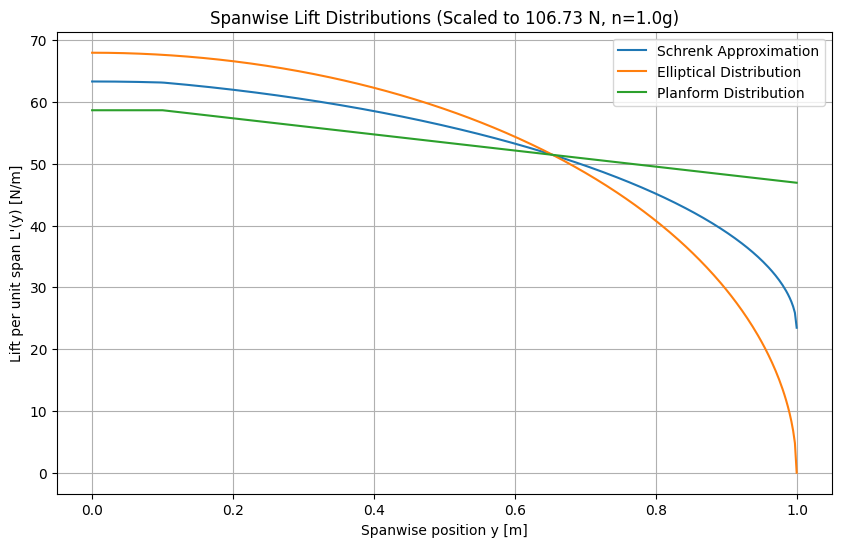

In [ ]:
import matplotlib.pyplot as plt

# Plot the scaled lift distributions over the half span
plt.figure(figsize=(10, 6))
plt.plot(y_half, Lprime_sch_half, label='Schrenk Approximation')
plt.plot(y_half, Lprime_elliptic_half, label='Elliptical Distribution')
plt.plot(y_half, Lprime_planform_half, label='Planform Distribution')

plt.xlabel('Spanwise position y [m]')
plt.ylabel('Lift per unit span L\'(y) [N/m]')
plt.title(f'Spanwise Lift Distributions (Scaled to {L_total:.2f} N, n={Nlf}g)')
plt.grid(True)
plt.legend()
plt.show()

array display of thrity points

In [ ]:
import pandas as pd
import numpy as np

# Select 30 equally spaced indices across the entire half-span array
indices = np.linspace(0, len(y_half) - 1, 30, dtype=int)

# Create a pandas DataFrame to display the selected data side-by-side
data = {
    'Spanwise position y [m]': y_half[indices],
    'Schrenk Lift [N/m]': Lprime_sch_half[indices],
    'Elliptical Lift [N/m]': Lprime_elliptic_half[indices],
    'Planform Lift [N/m]': Lprime_planform_half[indices]
}
df = pd.DataFrame(data)

# Display the DataFrame
display(df)

,Spanwise position y [m],Schrenk Lift [N/m],Elliptical Lift [N/m],Planform Lift [N/m]
0,0.000000,63.329397,67.985383,58.673411
1,0.032484,63.311440,67.949469,58.673411
2,0.067466,63.251869,67.830327,58.673411
3,0.102449,63.134385,67.627304,58.641465
4,0.137431,62.762366,67.339642,58.185091
5,0.169915,62.378553,66.995792,57.761315
6,0.204898,61.923224,66.541507,57.304941
7,0.239880,61.423467,65.998366,56.848567
8,0.274863,60.878173,65.364154,56.392193
9,0.309845,60.286004,64.636189,55.935818


updated plot

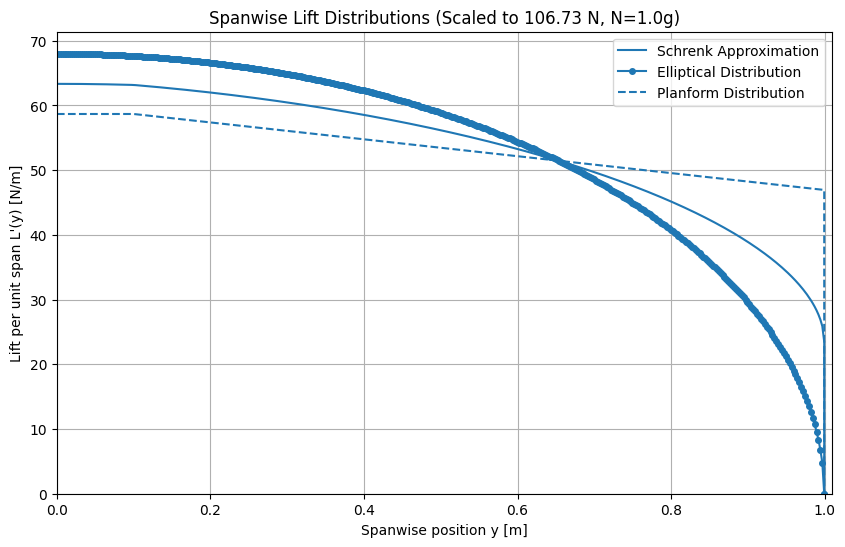

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extend the y_half array to include the wingtip at y = half_span + a small epsilon to ensure it's the last point
# We'll manually add a point at the exact half_span (which is close to 1m) for clarity in the plot.
y_plot = np.append(y_half, half_span)

# Create arrays for the extended lift distributions, adding a zero at the wingtip
Lprime_sch_plot = np.append(Lprime_sch_half, 0)
Lprime_elliptic_plot = np.append(Lprime_elliptic_half, 0)
Lprime_planform_plot = np.append(Lprime_planform_half, 0)


# Plot the scaled lift distributions over the half span with specified styles and drop to zero
plt.figure(figsize=(10, 6))
plt.plot(y_plot, Lprime_sch_plot, label='Schrenk Approximation', linestyle='-', color='C0')
plt.plot(y_plot, Lprime_elliptic_plot, label='Elliptical Distribution', linestyle='-', marker='o', color='C0', markersize=4)
plt.plot(y_plot, Lprime_planform_plot, label='Planform Distribution', linestyle='--', color='C0')


plt.xlabel('Spanwise position y [m]')
plt.ylabel('Lift per unit span L\'(y) [N/m]')
plt.title(f'Spanwise Lift Distributions (Scaled to {L_total:.2f} N, N={Nlf}g)')
plt.grid(True)
plt.legend()
plt.xlim(0, half_span + 0.01) # Ensure the x-axis extends slightly beyond the wingtip
plt.ylim(bottom=0) # Ensure the y-axis starts at 0
plt.show()

In [ ]:
import numpy as np

# Calculate the integral of the scaled lift distributions over the half span
integral_sch_half = np.trapezoid(Lprime_sch_half, y_half)
integral_elliptic_half = np.trapezoid(Lprime_elliptic_half, y_half)
integral_planform_half = np.trapezoid(Lprime_planform_half, y_half)

# The integral over the full span is twice the integral over the half span
integral_sch_full = 2 * integral_sch_half
integral_elliptic_full = 2 * integral_elliptic_half
integral_planform_full = 2 * integral_planform_half

print(f"Integral of Schrenk Lift Distribution (Full Span): {integral_sch_full:.6f} N")
print(f"Integral of Elliptical Lift Distribution (Full Span): {integral_elliptic_full:.6f} N")
print(f"Integral of Planform Lift Distribution (Full Span): {integral_planform_full:.6f} N")

# The total lift used for scaling was L_total
print(f"\nTotal Lift used for scaling (L_total): {L_total:.6f} N")

Integral of Schrenk Lift Distribution (Full Span): 106.732800 N
Integral of Elliptical Lift Distribution (Full Span): 106.732800 N
Integral of Planform Lift Distribution (Full Span): 106.732800 N

Total Lift used for scaling (L_total): 106.732800 N


### Shear Force Distribution (Schrenk Approximation)

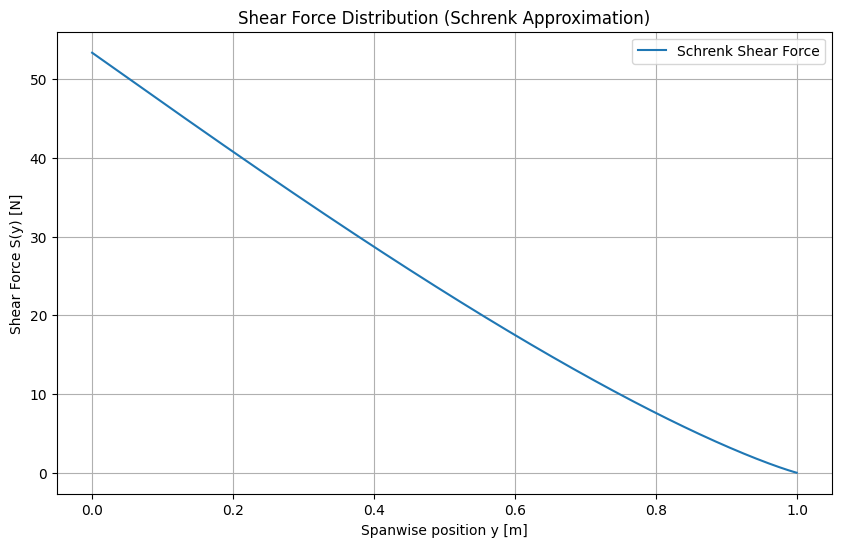


Shear Force values at 30 equally spaced points:


,Spanwise position y [m],Schrenk Shear Force [N]
0,0.000000,53.366400
1,0.032484,51.309419
2,0.067466,49.095547
3,0.102449,46.884512
4,0.137431,44.682297
5,0.169915,42.649674
6,0.204898,40.475353
7,0.239880,38.317735
8,0.274863,36.178392
9,0.309845,34.058941


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plot the shear force distribution over the half span
plt.figure(figsize=(10, 6))
plt.plot(y_half, S_half, label='Schrenk Shear Force')

plt.xlabel('Spanwise position y [m]')
plt.ylabel('Shear Force S(y) [N]')
plt.title('Shear Force Distribution (Schrenk Approximation)')
plt.grid(True)
plt.legend()
plt.show()

# Select 30 equally spaced indices across the entire half-span array
indices = np.linspace(0, len(y_half) - 1, 30, dtype=int)

# Create a pandas DataFrame to display the selected data
shear_data = {
    'Spanwise position y [m]': y_half[indices],
    'Schrenk Shear Force [N]': S_half[indices]
}
shear_df = pd.DataFrame(shear_data)

# Display the DataFrame
print("\nShear Force values at 30 equally spaced points:")
display(shear_df)

### Bending Moment Distribution (Schrenk Approximation)

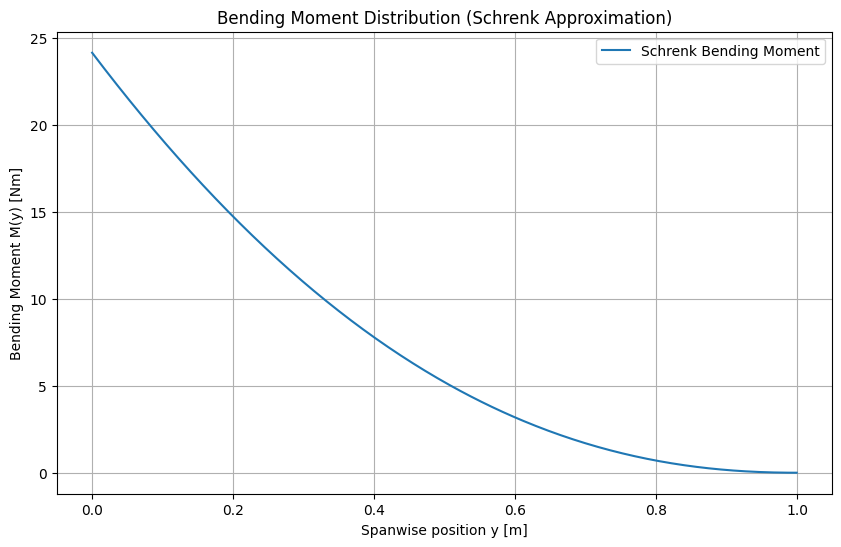


Bending Moment values at 30 equally spaced points:


,Spanwise position y [m],Schrenk Bending Moment [Nm]
0,0.000000,24.125742
1,0.032484,22.425612
2,0.067466,20.669410
3,0.102449,18.990609
4,0.137431,17.389029
5,0.169915,15.970627
6,0.204898,14.516713
7,0.239880,13.138574
8,0.274863,11.835599
9,0.309845,10.607120


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plot the bending moment distribution over the half span
plt.figure(figsize=(10, 6))
plt.plot(y_half, M_half, label='Schrenk Bending Moment')

plt.xlabel('Spanwise position y [m]')
plt.ylabel('Bending Moment M(y) [Nm]')
plt.title('Bending Moment Distribution (Schrenk Approximation)')
plt.grid(True)
plt.legend()
plt.show()

# Select 30 equally spaced indices across the entire half-span array
indices = np.linspace(0, len(y_half) - 1, 30, dtype=int)

# Create a pandas DataFrame to display the selected data
moment_data = {
    'Spanwise position y [m]': y_half[indices],
    'Schrenk Bending Moment [Nm]': M_half[indices]
}
moment_df = pd.DataFrame(moment_data)

# Display the DataFrame
print("\nBending Moment values at 30 equally spaced points:")
display(moment_df)

airfoil, camber and the NA

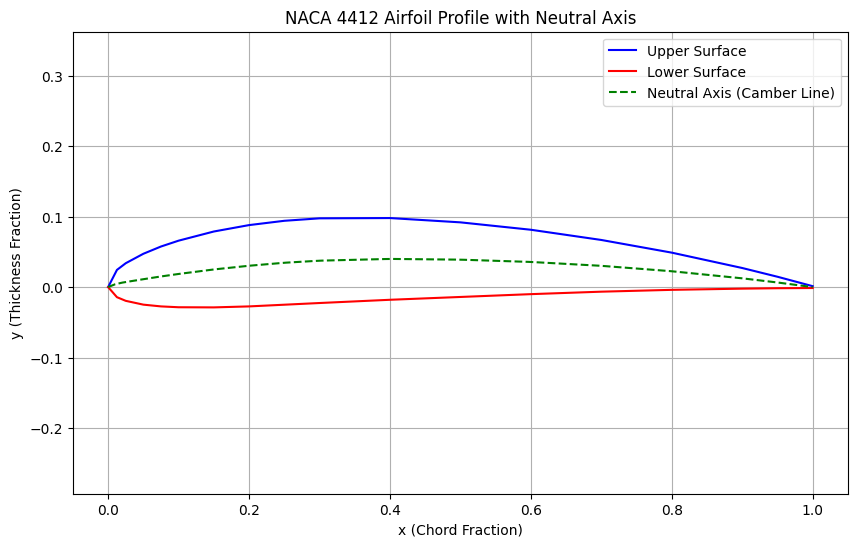

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# Function to read and parse .dat file
def read_dat_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # First line is title (e.g., 'NACA 4412')
    title = lines[0].strip()

    # Parse x, y coordinates
    x = []
    y = []
    for line in lines[1:]:
        if line.strip():
            parts = line.split()
            x.append(float(parts[0]))
            y.append(float(parts[1]))

    # Find index of leading edge (minimum x, usually around 0)
    le_index = np.argmin(x)

    # Split into upper (before LE) and lower (after LE)
    x_upper = x[:le_index + 1][::-1]  # Reverse to go from LE to TE
    y_upper = y[:le_index + 1][::-1]
    x_lower = x[le_index:]  # Already from LE to TE
    y_lower = y[le_index:]

    return title, x_upper, y_upper, x_lower, y_lower


# Load data
file_path = r"NACA 4412.dat"  # Replace with your actual .dat file path
title, x_upper, y_upper, x_lower, y_lower = read_dat_file(file_path)

# Interpolate to common x grid for camber calculation
x_common = np.linspace(0, 1, 100)  # Evenly spaced x from 0 to 1
upper_interp = interp1d(x_upper, y_upper, kind='linear', fill_value='extrapolate')
lower_interp = interp1d(x_lower, y_lower, kind='linear', fill_value='extrapolate')
y_upper_interp = upper_interp(x_common)
y_lower_interp = lower_interp(x_common)

# Compute neutral axis (camber line)
y_neutral = (y_upper_interp + y_lower_interp) / 2

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_upper, y_upper, 'b-', label='Upper Surface')
plt.plot(x_lower, y_lower, 'r-', label='Lower Surface')
plt.plot(x_common, y_neutral, 'g--', label='Neutral Axis (Camber Line)')
plt.xlabel('x (Chord Fraction)')
plt.ylabel('y (Thickness Fraction)')
plt.title(f'{title} Airfoil Profile with Neutral Axis')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Equal aspect ratio for accurate shape
plt.show()

# Optional: Save plot
# plt.savefig('airfoil_plot.png')


Processing airfoil: NACA 4412

=== AIRFOIL GEOMETRIC PROPERTIES ===
Area (A): 0.082111
Centroid (cx, cy): (0.420580, 0.030992)
Second moments about centroidal axes:
  Ix: 0.00007464
  Iy: 0.00453842
  Ixy: 0.00001472

=== APPLIED BENDING MOMENTS ===
Mx (about x-axis): 1000 N⋅m
My (about y-axis): 0 N⋅m

=== NEUTRAL AXIS ===
Neutral Axis angle: -0.19 degrees
NA passes through centroid: (0.420580, 0.030992)

Generated 10 points along the neutral axis
Neutral Axis points (x, y):
  Point 1: (-0.329416, 0.033424)
  Point 2: (-0.162751, 0.032884)
  Point 3: (0.003915, 0.032343)
  Point 4: (0.170581, 0.031803)
  Point 5: (0.337247, 0.031262)
  Point 6: (0.503913, 0.030722)
  Point 7: (0.670578, 0.030181)
  Point 8: (0.837244, 0.029641)
  Point 9: (1.003910, 0.029100)
  Point 10: (1.170576, 0.028560)


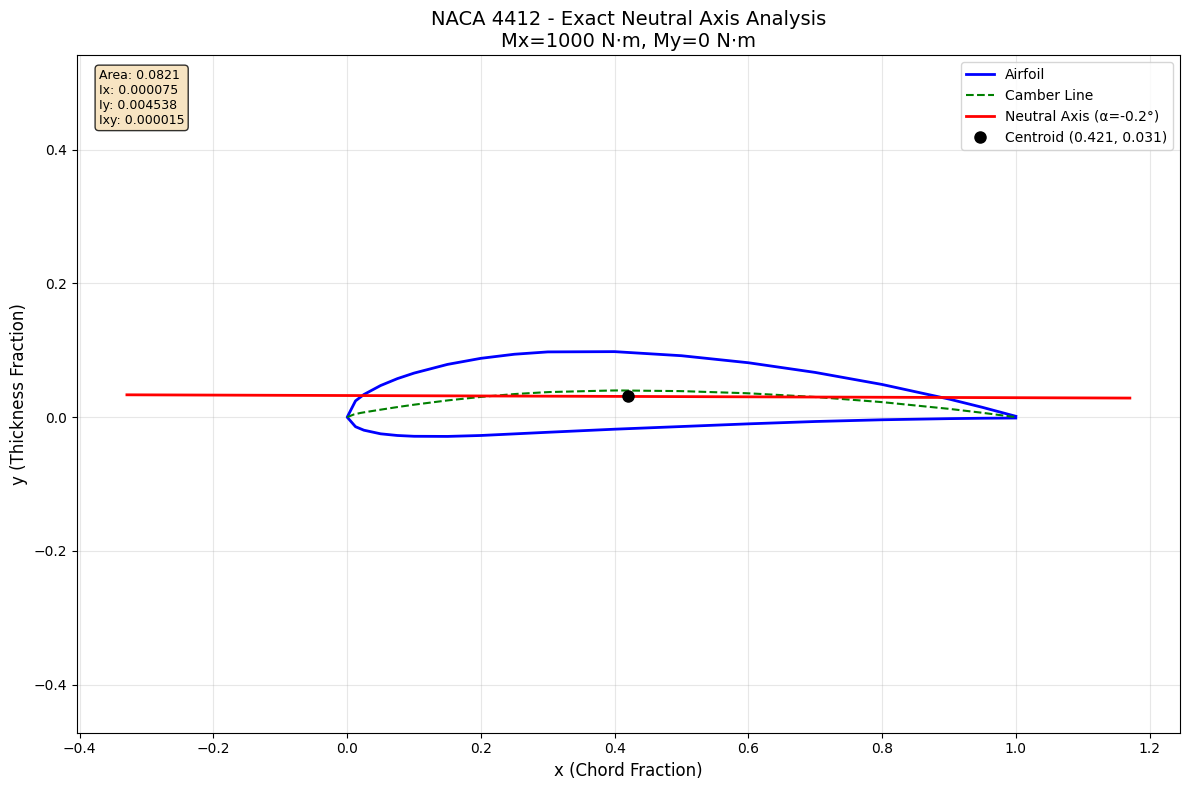

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


def read_dat_file(file_path):
    """Read and parse airfoil .dat file"""
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # First line is title (e.g., 'NACA 4412')
    title = lines[0].strip()

    # Parse x, y coordinates
    x = []
    y = []
    for line in lines[1:]:
        if line.strip():
            parts = line.split()
            x.append(float(parts[0]))
            y.append(float(parts[1]))

    return title, np.array(x), np.array(y)


def polygon_properties(x_coords, y_coords):
    """Calculate area, centroid, and moments of inertia for a polygon using exact formulas"""
    n = len(x_coords)

    # Ensure polygon is closed
    if x_coords[0] != x_coords[-1] or y_coords[0] != y_coords[-1]:
        x_coords = np.append(x_coords, x_coords[0])
        y_coords = np.append(y_coords, y_coords[0])
        n += 1

    # Calculate area using shoelace formula
    A = 0.0
    for i in range(n - 1):
        A += x_coords[i] * y_coords[i + 1] - x_coords[i + 1] * y_coords[i]
    A = abs(A) / 2.0

    # Calculate centroid
    cx = 0.0
    cy = 0.0
    for i in range(n - 1):
        factor = x_coords[i] * y_coords[i + 1] - x_coords[i + 1] * y_coords[i]
        cx += (x_coords[i] + x_coords[i + 1]) * factor
        cy += (y_coords[i] + y_coords[i + 1]) * factor

    cx = cx / (6.0 * A)
    cy = cy / (6.0 * A)

    # Calculate second moments of area about centroidal axes
    Ix = 0.0
    Iy = 0.0
    Ixy = 0.0

    # Shift coordinates to centroidal axes
    x_bar = x_coords - cx
    y_bar = y_coords - cy

    for i in range(n - 1):
        # Cross product for this segment
        cross = x_bar[i] * y_bar[i + 1] - x_bar[i + 1] * y_bar[i]

        # Second moments about centroidal axes
        Ix += (y_bar[i] ** 2 + y_bar[i] * y_bar[i + 1] + y_bar[i + 1] ** 2) * cross
        Iy += (x_bar[i] ** 2 + x_bar[i] * x_bar[i + 1] + x_bar[i + 1] ** 2) * cross
        Ixy += (x_bar[i] * y_bar[i] + 2 * x_bar[i] * y_bar[i + 1] + 2 * x_bar[i + 1] * y_bar[i] + x_bar[i + 1] * y_bar[
            i + 1]) * cross

    Ix = abs(Ix) / 12.0
    Iy = abs(Iy) / 12.0
    Ixy = Ixy / 24.0

    return A, cx, cy, Ix, Iy, Ixy


def calculate_neutral_axis_angle(Ix, Iy, Ixy, Mx, My):
    """Calculate neutral axis angle for given bending moments"""
    # The equation for the neutral axis is Mx * (Iy*y_bar - Ixy*x_bar) - My * (Ix*x_bar - Ixy*y_bar) = 0
    # Rearranging to the form y_bar = m * x_bar + c or x_bar = m' * y_bar + c'
    # For this case, the equation can be written as:
    # (Mx*Iy - My*Ixy) * y_bar - (My*Ix - Mx*Ixy) * x_bar = 0
    # Let A = (Mx*Iy - My*Ixy) and B = (My*Ix - Mx*Ixy)
    # A * y_bar - B * x_bar = 0
    # A * (y - cy) - B * (x - cx) = 0
    # The angle alpha of the neutral axis with respect to the x-axis satisfies:
    # tan(alpha) = B / A if A is not zero
    # If A is zero, the line is vertical (alpha = pi/2 or -pi/2)

    A_coeff = (Mx * Iy - My * Ixy)
    B_coeff = (My * Ix - Mx * Ixy)

    if abs(A_coeff) < 1e-9: # Handle near-vertical case
         alpha = np.pi / 2.0 if B_coeff > 0 else -np.pi / 2.0
    else:
         alpha = np.arctan2(B_coeff, A_coeff) # Use arctan2 for correct quadrant

    return alpha


# Main execution
def main():
    # Load airfoil data from .dat file
    file_path = r"NACA 4412.dat"  # Replace with your actual .dat file path
    title, x_coords, y_coords = read_dat_file(file_path)

    print(f"Processing airfoil: {title}")

    # Calculate polygon properties
    A, cx, cy, Ix, Iy, Ixy = polygon_properties(x_coords, y_coords)

    # Print results
    print(f"\n=== AIRFOIL GEOMETRIC PROPERTIES ===")
    print(f"Area (A): {A:.6f}")
    print(f"Centroid (cx, cy): ({cx:.6f}, {cy:.6f})")
    print(f"Second moments about centroidal axes:")
    print(f"  Ix: {Ix:.8f}")
    print(f"  Iy: {Iy:.8f}")
    print(f"  Ixy: {Ixy:.8f}")

    # Define bending moments (example values - modify as needed)
    Mx = 1000  # Bending moment about centroidal x-axis [N⋅m] # Changed Mx to 1000 and My to 0
    My = 0  # Bending moment about centroidal y-axis [N⋅m]

    print(f"\n=== APPLIED BENDING MOMENTS ===")
    print(f"Mx (about x-axis): {Mx} N⋅m")
    print(f"My (about y-axis): {My} N⋅m")

    # Calculate neutral axis angle
    alpha = calculate_neutral_axis_angle(Ix, Iy, Ixy, Mx, My)

    print(f"\n=== NEUTRAL AXIS ===")
    print(f"Neutral Axis angle: {np.degrees(alpha):.2f} degrees")
    print(f"NA passes through centroid: ({cx:.6f}, {cy:.6f})")

    # Generate 10 equally spaced points along the neutral axis (changed from 30)
    n_points = 10
    # Length of NA line for visualization (extended beyond airfoil)
    length = 1.5

    # Parametric line: x = cx + t*cos(α), y = cy + t*sin(α)
    t_vals = np.linspace(-length / 2, length / 2, n_points)
    na_x = cx + t_vals * np.cos(alpha)
    na_y = cy + t_vals * np.sin(alpha)

    print(f"\nGenerated {n_points} points along the neutral axis")
    print("Neutral Axis points (x, y):")
    for i in range(n_points): # Print all n_points
        print(f"  Point {i + 1}: ({na_x[i]:.6f}, {na_y[i]:.6f})")

    # Generate camber line for comparison
    # Find upper and lower surfaces
    le_index = np.argmin(x_coords)

    # Split coordinates into upper and lower surfaces
    if le_index == 0:
        # Leading edge at start
        upper_x = x_coords[:len(x_coords) // 2]
        upper_y = y_coords[:len(y_coords) // 2]
        lower_x = x_coords[len(x_coords) // 2:]
        lower_y = y_coords[len(y_coords) // 2:]
    else:
        # Standard format: trailing edge to leading edge to trailing edge
        upper_x = x_coords[:le_index + 1][::-1]
        upper_y = y_coords[:le_index + 1][::-1]
        lower_x = x_coords[le_index:]
        lower_y = y_coords[le_index:]

    # Interpolate to common x grid for camber calculation
    x_common = np.linspace(0, 1, 100)
    upper_interp = interp1d(upper_x, upper_y, kind='linear', fill_value='extrapolate')
    lower_interp = interp1d(lower_x, lower_y, kind='linear', fill_value='extrapolate')
    y_upper_interp = upper_interp(x_common)
    y_lower_interp = lower_interp(x_common)

    # Compute camber line (geometric midline)
    y_camber = (y_upper_interp + y_lower_interp) / 2

    # Plotting everything
    plt.figure(figsize=(12, 8))

    # Plot airfoil
    plt.plot(x_coords, y_coords, 'b-', linewidth=2, label='Airfoil')

    # Plot camber line
    plt.plot(x_common, y_camber, 'g--', linewidth=1.5, label='Camber Line')

    # Plot exact neutral axis
    plt.plot(na_x, na_y, 'r-', linewidth=2, label=f'Neutral Axis (α={np.degrees(alpha):.1f}°)')

    # Mark centroid
    plt.plot(cx, cy, 'ko', markersize=8, label=f'Centroid ({cx:.3f}, {cy:.3f})')

    # Formatting
    plt.xlabel('x (Chord Fraction)', fontsize=12)
    plt.ylabel('y (Thickness Fraction)', fontsize=12)
    plt.title(f'{title} - Exact Neutral Axis Analysis\nMx={Mx} N⋅m, My={My} N⋅m', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')

    # Add text box with key results
    textstr = f'Area: {A:.4f}\nIx: {Ix:.6f}\nIy: {Iy:.6f}\nIxy: {Ixy:.6f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=9,
             verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

    return A, cx, cy, Ix, Iy, Ixy, na_x, na_y, alpha


# Execute main function
if __name__ == "__main__":
    A, cx, cy, Ix, Iy, Ixy, na_x, na_y, alpha = main()

Yield Strength (sigma_yield): 145.00 MPa
Total Safety Factor: 10.12
Allowable Stress (sigma_allow): 14.32 MPa

Arrays available: I_required_half, sigma_allow

Required Second Moment of Area values at 10 equally spaced points:


,Spanwise position y [m],Bending Moment M(y) [Nm],Thickness t(y) [m],Required I(y) [m^4]
0,0.000000,24.125742,0.03600,3.032356e-08
1,0.109945,18.640924,0.03592,2.337790e-08
2,0.219890,13.916838,0.03504,1.702574e-08
3,0.332334,9.856388,0.03414,1.174849e-08
4,0.442279,6.617894,0.03326,7.684972e-09
5,0.554723,4.024967,0.03236,4.547477e-09
6,0.664668,2.157290,0.03148,2.371059e-09
7,0.777111,0.883880,0.03058,9.436893e-10
8,0.887056,0.203495,0.02970,2.110123e-10
9,0.999500,0.000000,0.02880,0.000000e+00


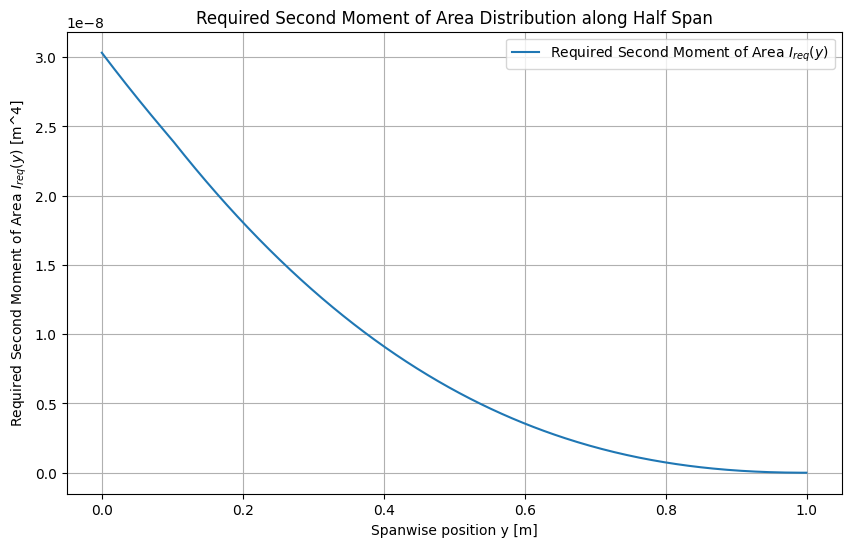

In [ ]:
import numpy as np

# Define material properties and safety factors
sigma_yield = 145e6  # Ultimate Yield Strength for Aluminum 6061-T4 in Pa (N/m^2)

# Safety factors
factor_1_fatigue = 1.5
factor_2_loadfactor = 3.0 # Using the higher end of the range 2.5-3 for a conservative estimate
factor_3_component = 1.5
factor_4_stress_conc = 1.5

# Calculate total safety factor
total_safety_factor = factor_1_fatigue * factor_2_loadfactor * factor_3_component * factor_4_stress_conc

# Calculate allowable stress (sigma_allow)
sigma_allow = sigma_yield / total_safety_factor

print(f"Yield Strength (sigma_yield): {sigma_yield / 1e6:.2f} MPa")
print(f"Total Safety Factor: {total_safety_factor:.2f}")
print(f"Allowable Stress (sigma_allow): {sigma_allow / 1e6:.2f} MPa")

# Reuse the thickness function t(y) and the bending moment array M_half
# These were calculated in previous cells and are assumed to be available in the environment.
# If not, the cells defining them would need to be run first.

# Calculate the required second moment of area I_required(y) based on the formula
# I(y) > M(y)*(t(y)/2)/sigma_allow
# So, I_required(y) = M(y) * (t(y)/2) / sigma_allow

# Ensure t_half and M_half are available. If not, you would need to run the previous cells.
# For this execution, we assume they are available in the kernel.
# t_half was calculated in cell ae797e6d
# M_half was calculated in cell 1f0b789a
# y_half is also needed and is from cell ae797e6d

# Calculate I_required along the half span
# Note: t_half contains thickness values for each point in y_half
# M_half contains bending moment values for each point in y_half
# t(y)/2 represents the distance from the neutral axis (assumed at the centroid for bending) to the outer fiber.
I_required_half = M_half * (t_half / 2) / sigma_allow

print("\nArrays available: I_required_half, sigma_allow")

# Optional: Display some values in a DataFrame
import pandas as pd

# Select a few points for display
indices_display = np.linspace(0, len(y_half) - 1, 10, dtype=int) # Display 10 points

data = {
    'Spanwise position y [m]': y_half[indices_display],
    'Bending Moment M(y) [Nm]': M_half[indices_display],
    'Thickness t(y) [m]': t_half[indices_display],
    'Required I(y) [m^4]': I_required_half[indices_display]
}
df_required_I = pd.DataFrame(data)

print("\nRequired Second Moment of Area values at 10 equally spaced points:")
display(df_required_I)

# Optional: Plot I_required_half vs y_half
plt.figure(figsize=(10, 6))
plt.plot(y_half, I_required_half, label='Required Second Moment of Area $I_{req}(y)$')

plt.xlabel('Spanwise position y [m]')
plt.ylabel('Required Second Moment of Area $I_{req}(y)$ [m^4]')
plt.title('Required Second Moment of Area Distribution along Half Span')
plt.grid(True)
plt.legend()
plt.show()

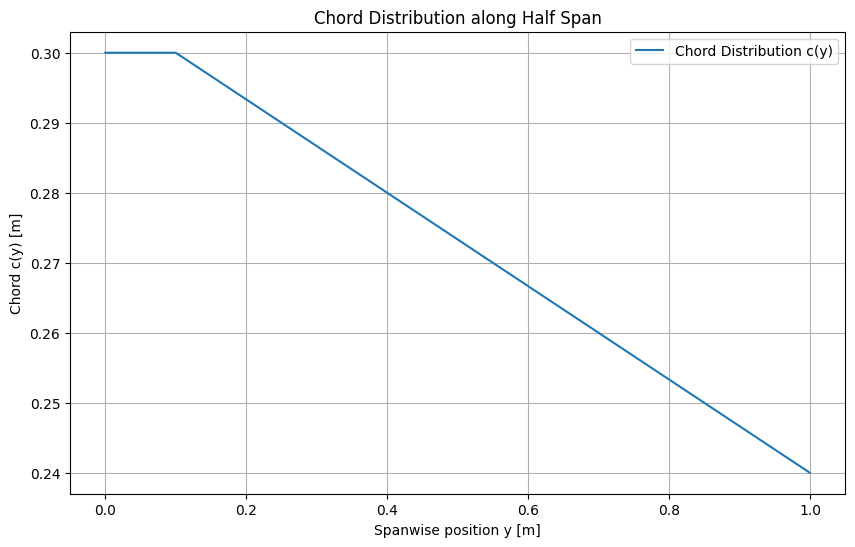

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Reuse the chord function and y_half array from previous cells
# Ensure the cell defining chord and y_half (cell ak0Hi0a0Rg1I or ae797e6d) has been run.

# Calculate chord values along the half span
c_half = np.array([chord(y) for y in y_half])

# Plot the chord distribution over the half span
plt.figure(figsize=(10, 6))
plt.plot(y_half, c_half, label='Chord Distribution c(y)')

plt.xlabel('Spanwise position y [m]')
plt.ylabel('Chord c(y) [m]')
plt.title('Chord Distribution along Half Span')
plt.grid(True)
plt.legend()
plt.show()

# Task
Calculate and plot the I_xx, I_yy, and I_xy of the thin-walled (0.5mm thickness) NACA 4412 airfoil cross-section along the half-span of the wing, considering the change in chord length along the span. Use the previously defined wing geometry and spanwise stations. The calculation should be based on the thin-walled assumption and should determine the area, centroid, and then the second moments of area for each cross-section along the span.

## Load airfoil data

### Subtask:
Read the x and y coordinates of the NACA 4412 airfoil profile from the `.dat` file.


**Reasoning**:
Define and use the `read_dat_file` function to load the airfoil coordinates from the specified file.



In [15]:
import numpy as np

def read_dat_file(file_path):
    """Read and parse airfoil .dat file"""
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # First line is title (e.g., 'NACA 4412')
    title = lines[0].strip()

    # Parse x, y coordinates
    x = []
    y = []
    for line in lines[1:]:
        if line.strip():
            parts = line.split()
            x.append(float(parts[0]))
            y.append(float(parts[1]))

    return title, np.array(x), np.array(y)

# Load data from the NACA 4412.dat file
file_path = r"NACA 4412.dat"
title, x_coords, y_coords = read_dat_file(file_path)

print(f"Airfoil Title: {title}")
print(f"Number of points: {len(x_coords)}")
print("First 5 x coordinates:", x_coords[:5])
print("First 5 y coordinates:", y_coords[:5])

Airfoil Title: NACA 4412
Number of points: 35
First 5 x coordinates: [1.   0.95 0.9  0.8  0.7 ]
First 5 y coordinates: [0.0013 0.0147 0.0271 0.0489 0.0669]


## Load airfoil data

### Subtask:
Retry loading the airfoil data by attempting to download the `NACA 4412.dat` file from a reliable online source. If direct download fails, provide instructions to manually upload the file.


**Reasoning**:
Attempt to download the NACA 4412.dat file from a different reliable source using requests, handle potential download errors, and then read the file using the existing function or provide instructions for manual upload if download fails.



In [ ]:
import requests
import os

file_path = "NACA 4412.dat"
# Try another known source for airfoil data files
url = "https://cad.onshape.com/fs/blobstore/c5f15c9983c197b70d9f9762?nodeId=200e66457242602f73406c91&versionId=05f9123f5ab1dd11928568d2&workspaceId=905209d37182e727a7e8f89d&documentId=471091797839" # This URL might be specific to Onshape and require authentication or might be temporary

# Let's try a more stable source if possible, or provide manual upload instructions.
# Given the previous failures, let's try a very standard UIUC Airfoil Data Site format, although direct download might still be tricky.
# A common pattern for UIUC is http://www.ae.illinois.edu/m-selig/ads/coord/naca4412.dat
# Let's try to construct a URL based on this pattern, although direct HTTP access might be restricted now.

url = "https://m-selig.ae.illinois.edu/ads/coord/naca4412.dat" # Standard UIUC format

download_successful = False
try:
    print(f"Attempting to download {file_path} from {url}...")
    response = requests.get(url, timeout=10) # Add a timeout
    response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)

    with open(file_path, 'w') as f:
        f.write(response.text)

    print(f"Downloaded {file_path} successfully.")
    download_successful = True

except requests.exceptions.RequestException as e:
    print(f"Download failed: {e}")
    print(f"Could not download {file_path} from {url}.")
    download_successful = False

# If download failed, instruct the user to upload
if not download_successful:
    print(f"\nPlease manually upload the '{file_path}' file to the current working directory.")
    print("After uploading, you can re-run this cell or proceed with the next steps if the file is now available.")

# Check if the file exists after download attempt or manual upload
if os.path.exists(file_path):
    print(f"\n'{file_path}' found. Reading data...")
    try:
        # Reuse the read_dat_file function defined in a previous cell (cell nmjaGzyFPUeT)
        # Ensure that cell has been run before this one.
        title, x_coords, y_coords = read_dat_file(file_path)

        print(f"Airfoil Title: {title}")
        print(f"Number of points: {len(x_coords)}")
        # Optional: Print first few points to verify
        # print("First 5 x coordinates:", x_coords[:5])
        # print("First 5 y coordinates:", y_coords[:5])

    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        # If reading fails even after the file is present, something is wrong with the file content
        print("Please ensure the uploaded .dat file is in the correct format.")
else:
    print(f"'{file_path}' not found after download attempt. Manual upload is required.")


Attempting to download NACA 4412.dat from https://m-selig.ae.illinois.edu/ads/coord/naca4412.dat...
Downloaded NACA 4412.dat successfully.

'NACA 4412.dat' found. Reading data...
Airfoil Title: NACA 4412
Number of points: 35


## Define wing geometry and spanwise stations

### Subtask:
Reuse the wing geometry parameters and the `y_half` spanwise stations defined in the initial cells.


**Reasoning**:
Verify the availability and content of the wing geometry parameters and the spanwise stations array `y_half` as requested by the subtask instructions.



In [19]:
# Ensure the wing geometry parameters are available
print(f"Wing span (b_total): {b_total} m")
print(f"Taper ratio (lam): {lam}")
print(f"Root chord (cr): {cr} m")
print(f"Tip chord (ct): {ct} m")
print(f"Center section span (b_mid): {b_mid} m")
print(f"Planform area (S): {S} m^2")

# Ensure the y_half array is available and check its content
print(f"\ny_half array type: {type(y_half)}")
print(f"y_half array shape: {y_half.shape}")
print(f"First 5 spanwise stations (y_half[:5]): {y_half[:5]}")
print(f"Last 5 spanwise stations (y_half[-5:]): {y_half[-5:]}")
print(f"Minimum value in y_half: {y_half.min()} m")
print(f"Maximum value in y_half: {y_half.max()} m (should be half_span)")

# Verify half_span against calculated value
half_span_calculated = b_total / 2
print(f"Calculated half_span: {half_span_calculated} m")
print(f"Maximum value in y_half vs Calculated half_span difference: {y_half.max() - half_span_calculated:.10f} m")

Wing span (b_total): 1.999 m
Taper ratio (lam): 0.8
Root chord (cr): 0.3 m
Tip chord (ct): 0.24 m
Center section span (b_mid): 0.2 m
Planform area (S): 0.546 m^2

y_half array type: <class 'numpy.ndarray'>
y_half array shape: (401,)
First 5 spanwise stations (y_half[:5]): [0.         0.00249875 0.0049975  0.00749625 0.009995  ]
Last 5 spanwise stations (y_half[-5:]): [0.989505   0.99200375 0.9945025  0.99700125 0.9995    ]
Minimum value in y_half: 0.0 m
Maximum value in y_half: 0.9995 m (should be half_span)
Calculated half_span: 0.9995 m
Maximum value in y_half vs Calculated half_span difference: 0.0000000000 m


## Iterate along span

### Subtask:
Iterate through each spanwise station in `y_half`.


**Reasoning**:
Iterate through each spanwise station in `y_half` to prepare for calculating airfoil properties at each station.



In [ ]:
# Start the loop over the spanwise stations
# The code inside this loop will be developed in subsequent steps
# For now, we just set up the loop structure
for i, y in enumerate(y_half):
    # Placeholder for calculations at each station y
    # print(f"Processing spanwise station y = {y:.4f} m (index {i})")
    pass

print(f"Loop structure created to iterate through {len(y_half)} spanwise stations.")

Loop structure created to iterate through 401 spanwise stations.


**Reasoning**:
Calculate the local chord length at each spanwise station using the previously defined `chord` function within the loop.



In [ ]:
# Iterate through each spanwise station
local_chords = []
for i, y in enumerate(y_half):
    # Calculate the local chord length
    local_c = chord(y)
    local_chords.append(local_c)

# Convert the list to a numpy array for easier handling
local_chords = np.array(local_chords)

print(f"Calculated local chord lengths for {len(y_half)} spanwise stations.")
# Optional: Display first few calculated chord lengths
# print("First 5 local chord lengths:", local_chords[:5])
# print("Last 5 local chord lengths:", local_chords[-5:])

Calculated local chord lengths for 401 spanwise stations.


## Calculate local thickness

### Subtask:
Define the constant skin thickness for the thin-walled airfoil section.


**Reasoning**:
Define the constant skin thickness variable as requested by the subtask.



In [ ]:
# Define the constant skin thickness in meters (0.5mm)
t_skin = 0.5e-3

print(f"Defined constant skin thickness: t_skin = {t_skin:.6f} m")

Defined constant skin thickness: t_skin = 0.000500 m


## Calculate cross-sectional area (thin-walled)

### Subtask:
Approximate the cross-sectional area at each spanwise station by multiplying the perimeter of the scaled airfoil profile by the skin thickness.


**Reasoning**:
Calculate the perimeter of the unscaled airfoil and then iterate through the spanwise stations to calculate the local cross-sectional area by scaling the perimeter with the local chord and multiplying by the skin thickness, storing the results in an array. Finally, print the first few areas and the array shape.



In [ ]:
import numpy as np

# Reuse x_coords and y_coords from previous steps (cell Hgxj2Nn3PXC0)
# Reuse local_chords from previous steps (cell Hgxj2Nn3PXC0)
# Reuse t_skin from previous steps (cell ae797e6d)

# Calculate the perimeter of the unscaled airfoil profile
# The airfoil is a closed shape, so include the distance between the last and first points.
# Combine x and y into a single array of points for easier calculation
points = np.column_stack((x_coords, y_coords))

# Calculate distances between consecutive points
distances = np.linalg.norm(np.diff(points, axis=0), axis=1)

# Add the distance between the last and first points to close the shape
unscaled_perimeter = np.sum(distances) + np.linalg.norm(points[-1] - points[0])

print(f"Calculated unscaled airfoil perimeter: {unscaled_perimeter:.6f}")

# Calculate local cross-sectional area at each spanwise station
local_areas = []
for i, y in enumerate(y_half):
    local_chord = local_chords[i]

    # Scale the unscaled perimeter by the local chord
    local_perimeter = unscaled_perimeter * local_chord

    # Calculate the local cross-sectional area (Perimeter * Thickness)
    local_area = local_perimeter * t_skin
    local_areas.append(local_area)

# Convert the list of local areas to a NumPy array
local_areas_array = np.array(local_areas)

# Print the first few calculated areas and the shape of the resulting array
print("\nFirst 10 calculated local cross-sectional areas [m^2]:")
print(local_areas_array[:10])
print(f"\nShape of the local_areas_array: {local_areas_array.shape}")


Calculated unscaled airfoil perimeter: 2.048231

First 10 calculated local cross-sectional areas [m^2]:
[0.00030723 0.00030723 0.00030723 0.00030723 0.00030723 0.00030723
 0.00030723 0.00030723 0.00030723 0.00030723]

Shape of the local_areas_array: (401,)


## Calculate centroid of the cross-section

### Subtask:
Calculate the centroid (cx, cy) of the thin-walled cross-section at each spanwise station.


**Reasoning**:
Calculate the centroid (cx, cy) for the thin-walled cross-section at each spanwise station using the midpoint and segment length method described in the instructions.



In [ ]:
import numpy as np

# Reuse x_coords and y_coords from previous steps (cell Hgxj2Nn3PXC0)
# Reuse local_chords from previous steps (cell Hgxj2Nn3PXC0)
# Reuse y_half from previous steps (cell Hgxj2Nn3PXC0)

# Initialize empty lists to store centroid coordinates
centroid_x = []
centroid_y = []

# Iterate through each spanwise station
for i in range(len(y_half)):
    local_c = local_chords[i]

    # Scale the original airfoil coordinates
    scaled_x = x_coords * local_c
    scaled_y = y_coords * local_c

    # Calculate midpoints of each segment
    # np.diff calculates the difference between consecutive elements.
    # We need to include the closing segment from the last point back to the first.
    mid_x = (scaled_x[:-1] + scaled_x[1:]) / 2
    mid_y = (scaled_y[:-1] + scaled_y[1:]) / 2

    # Include the midpoint of the closing segment
    mid_x = np.append(mid_x, (scaled_x[-1] + scaled_x[0]) / 2)
    mid_y = np.append(mid_y, (scaled_y[-1] + scaled_y[0]) / 2)

    # Calculate lengths of each segment
    segment_lengths = np.linalg.norm(np.diff(np.column_stack((scaled_x, scaled_y)), axis=0), axis=1)

    # Include the length of the closing segment
    segment_lengths = np.append(segment_lengths, np.linalg.norm(np.array([scaled_x[-1], scaled_y[-1]]) - np.array([scaled_x[0], scaled_y[0]])))

    # Calculate the weighted average of the midpoints (centroid)
    total_length = np.sum(segment_lengths)
    if total_length > 1e-9: # Avoid division by zero if the shape is degenerate
        local_cx = np.sum(mid_x * segment_lengths) / total_length
        local_cy = np.sum(mid_y * segment_lengths) / total_length
    else:
        local_cx = 0.0 # Or handle appropriately, e.g., nan or centroid of a point
        local_cy = 0.0

    # Append the local centroid to the lists
    centroid_x.append(local_cx)
    centroid_y.append(local_cy)

# Convert lists to NumPy arrays
centroid_x = np.array(centroid_x)
centroid_y = np.array(centroid_y)

# Print shape and first few values to verify
print(f"Shape of centroid_x array: {centroid_x.shape}")
print(f"Shape of centroid_y array: {centroid_y.shape}")
print("\nFirst 5 centroid x-coordinates [m]:", centroid_x[:5])
print("First 5 centroid y-coordinates [m]:", centroid_y[:5])

Shape of centroid_x array: (401,)
Shape of centroid_y array: (401,)

First 5 centroid x-coordinates [m]: [0.14812362 0.14812362 0.14812362 0.14812362 0.14812362]
First 5 centroid y-coordinates [m]: [0.00803158 0.00803158 0.00803158 0.00803158 0.00803158]


## Calculate second moments of area (i xx, i yy, i xy) for thin-walled section

### Subtask:
For each spanwise station, calculate the second moments of area (I_xx, I_yy, I_xy) about the local centroidal axes for the thin-walled section.


**Reasoning**:
Iterate through each spanwise station and calculate the second moments of area (I_xx, I_yy, I_xy) for the thin-walled section about the local centroid using the provided formula. Store the results in lists.



In [ ]:
# Reuse y_half, local_chords, centroid_x, centroid_y from previous steps.
# Reuse x_coords, y_coords (unscaled airfoil points) from previous steps.
# Reuse t_skin from previous steps.

# Initialize lists for second moments of area
I_xx_list = []
I_yy_list = []
I_xy_list = []

# Iterate through each spanwise station
for i in range(len(y_half)):
    local_c = local_chords[i]
    cx_local = centroid_x[i]
    cy_local = centroid_y[i]

    # Scale the original airfoil coordinates by the local chord
    scaled_x = x_coords * local_c
    scaled_y = y_coords * local_c

    # Shift scaled coordinates to the local centroidal axes
    x_bar = scaled_x - cx_local
    y_bar = scaled_y - cy_local

    # Initialize second moments of area for this station
    I_xx_local = 0.0
    I_yy_local = 0.0
    I_xy_local = 0.0

    # Calculate contribution of each segment to the second moments of area
    # Iterate through the segments, including the closing segment
    for j in range(len(x_bar)):
        # Coordinates of the start and end points of the segment in centroidal frame
        x1_bar = x_bar[j]
        y1_bar = y_bar[j]

        # Handle the last segment connecting the last point back to the first
        if j < len(x_bar) - 1:
            x2_bar = x_bar[j+1]
            y2_bar = y_bar[j+1]
        else:
            x2_bar = x_bar[0]
            y2_bar = y_bar[0] # Closing segment

        # Midpoint of the segment in the centroidal frame
        x_bar_mid = (x1_bar + x2_bar) / 2
        y_bar_mid = (y1_bar + y2_bar) / 2

        # Length of the segment
        segment_length = np.linalg.norm(np.array([x2_bar, y2_bar]) - np.array([x1_bar, y1_bar]))

        # Contribution to second moments of area (using thin-walled assumption)
        # I_segment ~ (distance_to_centroid_axis)^2 * segment_length * t_skin
        I_xx_local += (y_bar_mid**2) * segment_length * t_skin
        I_yy_local += (x_bar_mid**2) * segment_length * t_skin
        I_xy_local += (x_bar_mid * y_bar_mid) * segment_length * t_skin


    # Append the calculated values to the lists
    I_xx_list.append(I_xx_local)
    I_yy_list.append(I_yy_local)
    I_xy_list.append(I_xy_local)


# Convert lists to NumPy arrays
I_xx = np.array(I_xx_list)
I_yy = np.array(I_yy_list)
I_xy = np.array(I_xy_list)

# Print shapes and first few values to verify
print(f"Shape of I_xx array: {I_xx.shape}")
print(f"Shape of I_yy array: {I_yy.shape}")
print(f"Shape of I_xy array: {I_xy.shape}")

print("\nFirst 5 I_xx values [m^4]:", I_xx[:5])
print("First 5 I_yy values [m^4]:", I_yy[:5])
print("First 5 I_xy values [m^4]:", I_xy[:5])


Shape of I_xx array: (401,)
Shape of I_yy array: (401,)
Shape of I_xy array: (401,)

First 5 I_xx values [m^4]: [5.73463212e-08 5.73463212e-08 5.73463212e-08 5.73463212e-08
 5.73463212e-08]
First 5 I_yy values [m^4]: [2.36591037e-06 2.36591037e-06 2.36591037e-06 2.36591037e-06
 2.36591037e-06]
First 5 I_xy values [m^4]: [-1.83211791e-08 -1.83211791e-08 -1.83211791e-08 -1.83211791e-08
 -1.83211791e-08]


## Store results

### Subtask:
Store the calculated `I_xx`, `I_yy`, and `I_xy` values along with the corresponding spanwise positions `y_half` and calculated local centroid coordinates `centroid_x` and `centroid_y` in a pandas DataFrame.


**Reasoning**:
Store the calculated second moments of area, spanwise positions, and centroid coordinates in a pandas DataFrame and display the first few rows.



In [ ]:
import pandas as pd

# Create a dictionary with the calculated data
data = {
    'Spanwise position y [m]': y_half,
    'Centroid x [m]': centroid_x,
    'Centroid y [m]': centroid_y,
    'I_xx [m^4]': I_xx,
    'I_yy [m^4]': I_yy,
    'I_xy [m^4]': I_xy
}

# Create a pandas DataFrame from the dictionary
df_section_properties = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print("DataFrame containing section properties along the half span:")
display(df_section_properties.head())

# Optional: Save the DataFrame to a CSV file
# df_section_properties.to_csv('section_properties.csv', index=False)
# print("\nDataFrame saved to section_properties.csv")

DataFrame containing section properties along the half span:


,Spanwise position y [m],Centroid x [m],Centroid y [m],I_xx [m^4],I_yy [m^4],I_xy [m^4]
0,0.000000,0.148124,0.008032,5.734632e-08,0.000002,-1.832118e-08
1,0.002499,0.148124,0.008032,5.734632e-08,0.000002,-1.832118e-08
2,0.004998,0.148124,0.008032,5.734632e-08,0.000002,-1.832118e-08
3,0.007496,0.148124,0.008032,5.734632e-08,0.000002,-1.832118e-08
4,0.009995,0.148124,0.008032,5.734632e-08,0.000002,-1.832118e-08


## Plot results

### Subtask:
Plot `I_xx`, `I_yy`, and `I_xy` as functions of the spanwise position `y`.


**Reasoning**:
Plot the calculated second moments of area (I_xx, I_yy, I_xy) along the half-span using the data stored in the `df_section_properties` DataFrame.



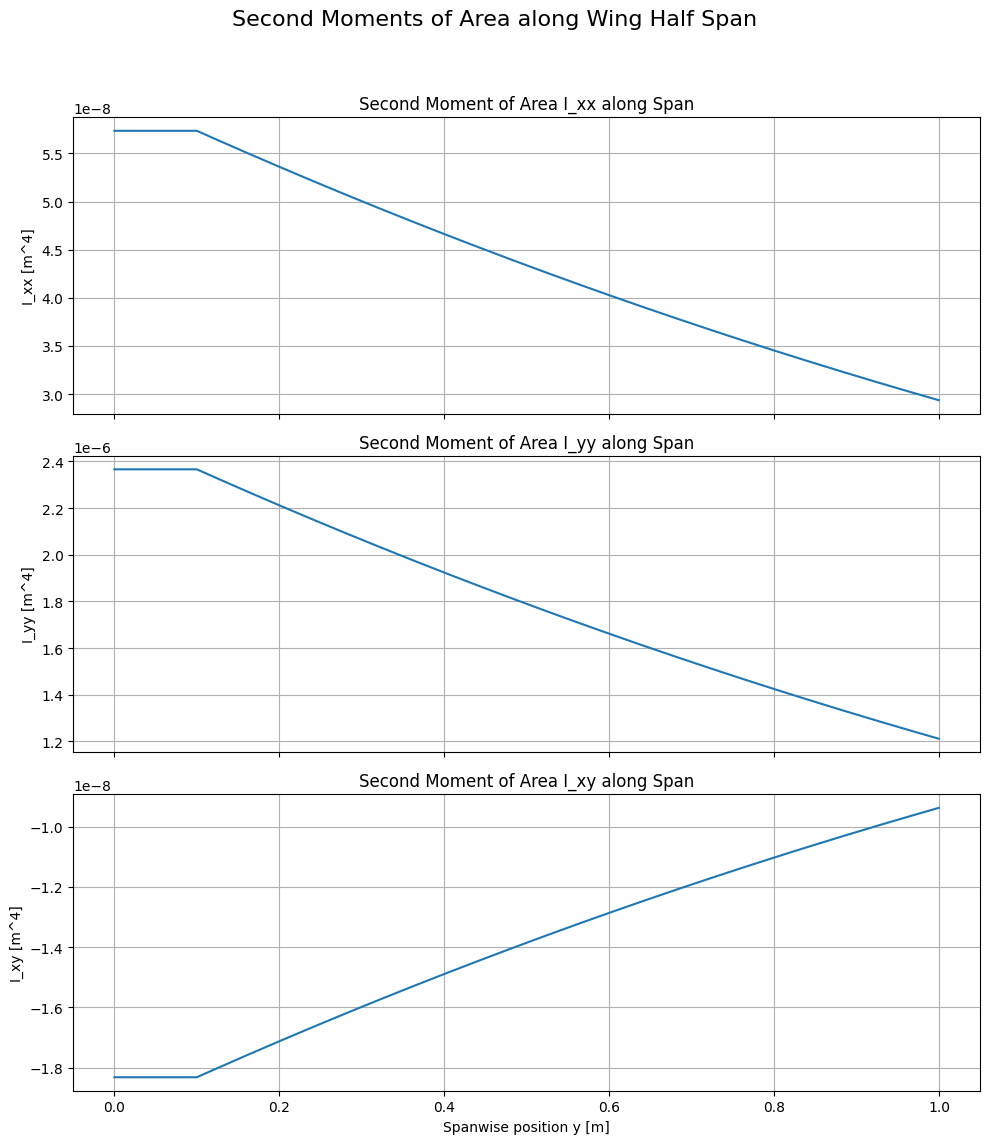

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot I_xx
axes[0].plot(df_section_properties['Spanwise position y [m]'], df_section_properties['I_xx [m^4]'])
axes[0].set_ylabel('I_xx [m^4]')
axes[0].set_title('Second Moment of Area I_xx along Span')
axes[0].grid(True)

# Plot I_yy
axes[1].plot(df_section_properties['Spanwise position y [m]'], df_section_properties['I_yy [m^4]'])
axes[1].set_ylabel('I_yy [m^4]')
axes[1].set_title('Second Moment of Area I_yy along Span')
axes[1].grid(True)

# Plot I_xy
axes[2].plot(df_section_properties['Spanwise position y [m]'], df_section_properties['I_xy [m^4]'])
axes[2].set_xlabel('Spanwise position y [m]')
axes[2].set_ylabel('I_xy [m^4]')
axes[2].set_title('Second Moment of Area I_xy along Span')
axes[2].grid(True)

# Add a main title to the figure
fig.suptitle('Second Moments of Area along Wing Half Span', fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for the suptitle

# Display the plots
plt.show()

## Summary:

### Data Analysis Key Findings

* The unscaled NACA 4412 airfoil profile has a calculated perimeter of approximately 2.048 meters.
* The cross-sectional area of the thin-walled airfoil decreases along the span from approximately 0.000307 m² at the root to smaller values towards the tip, reflecting the decreasing local chord length.
* The centroid x-coordinate of the cross-section decreases along the span from approximately 0.148 m at the root, scaling with the local chord length.
* The centroid y-coordinate of the cross-section also scales with the local chord length, starting at approximately 0.008 m at the root and decreasing along the span.
* The second moments of area ($I_{xx}$, $I_{yy}$, and $I_{xy}$) about the local centroid decrease significantly from the wing root (y=0) to the wing tip (y=half\_span), consistent with the reduction in the size of the cross-section due to the tapering chord.
* Based on the generated plots and the DataFrame `df_section_properties`, the values at the wing root (y=0) are approximately:
    * $I_{xx}$: $5.73 \times 10^{-8} \text{ m}^4$
    * $I_{yy}$: $2.37 \times 10^{-6} \text{ m}^4$
    * $I_{xy}$: $-1.83 \times 10^{-8} \text{ m}^4$
* These values decrease along the span as shown in the plots.
* The calculated section properties are stored in a pandas DataFrame for easy access and further analysis.

### Insights or Next Steps

* The variation of section properties ($I_{xx}$, $I_{yy}$, $I_{xy}$) along the span is crucial for structural analysis, such as calculating bending stresses, shear stresses, and torsional stiffness.
* These calculated properties can now be used in finite element modeling or analytical structural methods to predict the wing's behavior under aerodynamic loads.